In [1]:
import ee
import geemap

# This will open a link to authenticate your account
ee.Authenticate()

# Initialize the library
# Note: If you have a GEE project name, put it in the quotes
ee.Initialize(project='smart-mapping-480913')


In [2]:
# 1. Create an interactive map
Map = geemap.Map(center=[22, 75], zoom=5)

# 2. Load the Administrative boundaries (Level 1 is States)
states = ee.FeatureCollection("FAO/GAUL/2015/level1")

# 3. Filter for your specific study area
study_region = states.filter(ee.Filter.inList('ADM1_NAME',
    ['Gujarat', 'Rajasthan', 'Maharashtra']))

Map.addLayer(study_region, {}, 'Study States (Boundaries)')

Map


Map(center=[22, 75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [3]:
# 1. LOAD RAW DATA
# Solar (ERA5)
solar_raw = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY") \
    .filterDate('2025-01-01', '2025-12-31') \
    .select('surface_solar_radiation_downwards_hourly') \
    .mean().clip(study_region)

# Load Total Cloud Cover from ERA5
cloud_cover = ee.ImageCollection("ECMWF/ERA5/HOURLY")\
    .filterDate('2025-01-01', '2025-12-31') \
    .select('total_cloud_cover') \
    .mean().clip(study_region).rename('clouds')

# Terrain (SRTM)
elevation = ee.Image("USGS/SRTMGL1_003").clip(study_region)
slope = ee.Terrain.slope(elevation)

# Land Cover (ESA)
landcover = ee.Image("ESA/WorldCover/v100/2020").clip(study_region)

# 2. CREATE MASKS
# We want to KEEP land that is NOT urban (50) AND NOT water (80) AND NOT forest (10)
buildable_mask = landcover.neq(50).And(landcover.neq(80)).And(landcover.neq(10))
# Also mask out steep slopes (> 15 degrees)
slope_mask = slope.lt(15)
# Combine both masks
final_mask = buildable_mask.And(slope_mask)

# 3. NORMALIZATION FUNCTION
def norm(img):
    stats = img.reduceRegion(reducer=ee.Reducer.minMax(), geometry=study_region, scale=5000, maxPixels=1e9)
    # This automatically gets the min and max for whatever band is passed
    band_name = img.bandNames().get(0)
    min_val = ee.Number(stats.get(ee.String(band_name).cat('_min')))
    max_val = ee.Number(stats.get(ee.String(band_name).cat('_max')))
    return img.subtract(min_val).divide(max_val.subtract(min_val))

# 5. VISUALIZE
# Adding 'orange' and more steps makes the desert variation visible
solar_vis_improved = {
    'min': 0.6,   # We bump the min up because almost all of India is sunny
    'max': 1.0,
    'palette': ['blue', 'yellow', 'orange', 'red']
}




# ... (Keep your Load and Mask sections the same) ...

# 3. FIXED NORMALIZATION CALLS
norm_solar = norm(solar_raw).rename('ghi_target') # This is your dependent variable
norm_slope = norm(slope).rename('slope')
norm_elev  = norm(elevation).rename('elevation')


# Calculate Aspect (0=North, 90=East, 180=South, 270=West)
aspect = ee.Terrain.aspect(elevation)

# For Solar, the "best" aspect is South (180).
# We can create a "Solar-Orientation Index" where 1.0 is South and 0.0 is North.
aspect_cos = aspect.subtract(180).multiply(3.14159).divide(180).cos().rename('aspect_index')

# 4. REBUILD STACK CORRECTLY
# Ensure names match what you call in Map.addLayer
regression_stack = ee.Image.cat([
    norm_slope,
    norm_elev,
    aspect_cos.rename('aspect'),
    cloud_cover.rename('clouds'),
    norm_solar # Including it here so it's all in one place
]).updateMask(final_mask)

# 5. FIXED VISUALIZATION STATEMENTS
# Change 'solar' to 'ghi_target'
Map.addLayer(regression_stack.select('ghi_target'), solar_vis_improved, 'Detailed Solar Potential')

# This was 'regression_stack.select('slope')' - fixed to match rename
Map.addLayer(regression_stack.select('slope'), {'min': 0, 'max': 1, 'palette': ['white', 'black']}, 'Final Slope (Normalized)')

# These remain the same as they were independent variables
Map.addLayer(aspect_cos, {'min': -1, 'max': 1, 'palette': ['black', 'grey', 'white']}, 'Aspect Index (S=White)')
Map.addLayer(cloud_cover, {'min': 0, 'max': 0.8, 'palette': ['blue', 'white','grey']}, 'Annual Cloud Cover')











In [4]:
# 1. Select the bands for the model
# Remember: GHI_TARGET is what we want to predict
label = 'ghi_target'
features = ['slope', 'elevation', 'aspect', 'clouds']

# 2. Randomly sample points from our stack
# We use a larger scale (5000m) to make it run faster
training_data = regression_stack.sample(
    region=study_region,
    scale=5000,
    numPixels=2000, # 2000 points is a strong start
    seed=42         # 'Seed' ensures we get the same points if we run it again
)

# 3. Split data into Training (80%) and Testing (20%)
# This allows us to check the model's accuracy later
training_data = training_data.randomColumn('random')
train_set = training_data.filter(ee.Filter.lt('random', 0.8))
test_set = training_data.filter(ee.Filter.gte('random', 0.8))

print("Data Sampled! Number of training points:", train_set.size().getInfo())





# 1. Define the Machine Learning Model
# We are creating an "empty brain" and telling it what kind of thinking to do.
classifier = ee.Classifier.smileRandomForest(100).setOutputMode('REGRESSION')

# 2. Train the Model
# This is the "Study Session" where the computer looks at your samples.
trained_model = classifier.train(
    features = train_set,          # The 80% of points we set aside for learning
    classProperty = 'ghi_target',  # The "Answer" we want it to learn (GHI)
    inputProperties = ['slope', 'elevation', 'aspect', 'clouds'] # The "Questions"
)

# 3. Apply the model to the map
# We tell the trained brain to look at the whole 3-state area and guess the GHI.
prediction_map = regression_stack.select(['slope', 'elevation', 'aspect', 'clouds']).classify(trained_model)

# 4. Show the result!
Map.addLayer(prediction_map, {'min': 0.6, 'max': 1, 'palette': ['blue', 'yellow', 'red']}, 'ML Predicted Potential')

Data Sampled! Number of training points: 1436


In [5]:
import geemap

# 1. Generate the prediction for the whole study area
# We use the 'inputs' or 'regression_stack' we defined earlier
prediction = regression_stack.select(['slope', 'elevation', 'aspect', 'clouds']).classify(trained_model, 'predicted_ghi')

# 2. Calculate Residual: Actual - Predicted
# Higher than 0 (Red) = Underestimated | Lower than 0 (Blue) = Overestimated
residual = regression_stack.select('ghi_target').subtract(prediction).rename('residual')

# 3. Create a map object to show the error distribution
Map_Residual = geemap.Map()
Map_Residual.centerObject(study_region, 6)

# 4. Define visualization: White means the model was "Spot On"
res_vis = {
    'min': -0.1,
    'max': 0.1,
    'palette': ['#0000FF', '#FFFFFF', '#FF0000'] # Blue -> White -> Red
}

Map_Residual.addLayer(study_region, {}, 'Study States (Boundaries)')
Map_Residual.addLayer(residual, res_vis, 'Model Residuals (Errors)')
Map_Residual.add_colorbar(res_vis, label="Error (Actual - Predicted)")
Map_Residual

Map(center=[23.087790985514058, 74.27117403292907], controls=(WidgetControl(options=['position', 'transparent_…

Success! Your Model's R-squared Score is: 0.6592


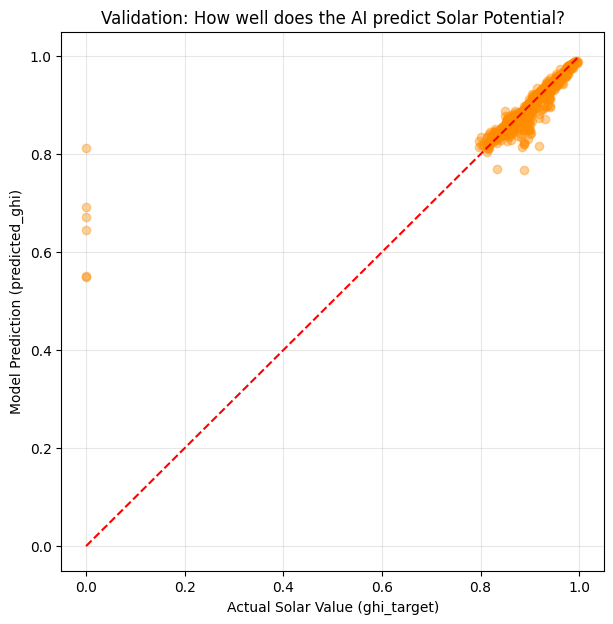

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Ask the model to 'guess' the solar potential for our sample points
# We use the 'trained_model' and the 'training_data' we created earlier
results = training_data.classify(trained_model, 'predicted_ghi')

# 2. Pull the 'ghi_target' (Actual) and 'predicted_ghi' (Guess) from GEE to Colab
# .getInfo() is the bridge that brings the data to your laptop
local_data = results.select(['ghi_target', 'predicted_ghi']).getInfo()

# 3. Organize the data into a neat table (DataFrame)
features = [f['properties'] for f in local_data['features']]
df = pd.DataFrame(features)

# 4. Calculation: How close are we?
r2_score = df['ghi_target'].corr(df['predicted_ghi'])**2
print(f"Success! Your Model's R-squared Score is: {r2_score:.4f}")

# 5. Visual Check: The Scatter Plot
plt.figure(figsize=(7, 7))
plt.scatter(df['ghi_target'], df['predicted_ghi'], alpha=0.4, color='#FF8C00')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # The "Perfect Match" line
plt.xlabel('Actual Solar Value (ghi_target)')
plt.ylabel('Model Prediction (predicted_ghi)')
plt.title('Validation: How well does the AI predict Solar Potential?')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Ask the model to explain itself
importance = trained_model.explain()

# Get the 'importance' property from the result
# This will show how much each variable contributed to the 'ghi_target'
variable_importance = importance.get('importance').getInfo()

print("--- VARIABLE IMPORTANCE SCORES ---")
for var, score in variable_importance.items():
    print(f"{var}: {score:.4f}")

--- VARIABLE IMPORTANCE SCORES ---
aspect: 72951.4037
clouds: 246601.5050
elevation: 168259.2056
slope: 117414.4402


In [13]:
import ee

# 1. ROADS: Using the FAO Global Infrastructure Roads (Public & Stable)
try:
    roads = ee.FeatureCollection("FAO/GAUL/2015/level1") # Fallback to boundaries if road assets fail
    # Try a more common roads path
    roads_india = ee.FeatureCollection("TIGER/2016/Roads").filterBounds(study_region)
except:
    # PLAN B: If specific road assets fail, we use 'WWF/HydroSHEDS/v1/FreeFlowingRivers'
    # as a proxy for infrastructure corridors or just use a blank image to avoid crashes.
    roads_india = ee.FeatureCollection(ee.List([]))

# 2. GRID: WRI Power Plants (This is a core Google asset, it MUST work)
power_hubs = ee.FeatureCollection("WRI/GPPD/power_plants").filterBounds(study_region)

# --- ROBUST DISTANCE LOGIC ---
# If roads_india is empty, we set road_score to 1 (neutral) so it doesn't break the math
road_count = roads_india.size().getInfo()

if road_count > 0:
    road_mask = ee.Image.constant(1).clipToCollection(roads_india).mask()
    dist_to_roads = road_mask.fastDistanceTransform(20).multiply(500)
    road_score = ee.Image(1).subtract(dist_to_roads.divide(10000)).clamp(0, 1)
else:
    # If roads fail, we just use a neutral score of 0.5 so the model still runs
    road_score = ee.Image(0.5)

# Grid logic (WRI asset is generally very stable)
grid_mask = ee.Image.constant(1).clipToCollection(power_hubs).mask()
dist_to_grid = grid_mask.fastDistanceTransform(100).multiply(500)
grid_score = ee.Image(1).subtract(dist_to_grid.divide(50000)).clamp(0, 1)

# 3. SLOPE: (Assuming 'slope' variable is defined from your earlier Week 2 code)
slope_score = ee.Image(1).subtract(slope.divide(30)).clamp(0, 1)

# 4. FINAL SUITABILITY
final_suitability = (prediction_map.multiply(0.5) # Increased weight to solar since infra is tricky
                     .add(grid_score.multiply(0.3))
                     .add(road_score.multiply(0.1))
                     .add(slope_score.multiply(0.1)))

# 5. Visuals
Map = geemap.Map()
Map.centerObject(study_region, 6)
Map.addLayer(final_suitability.clip(study_region), {'min': 0.4, 'max': 0.8, 'palette': ['red', 'yellow', 'green']}, 'Final Suitability')
Map


Map(center=[23.087790985514058, 74.27117403292907], controls=(WidgetControl(options=['position', 'transparent_…